### Path Changes from John Hopkins :

New paths were data will be updated, and secondly the archived links if eeded for troubleshooting etc. Change made 25.03

In [2]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_covid19_confirmed_global.csv')
DEATHS = pd.read_csv(main_link+'time_series_covid19_deaths_global.csv')
RECOVERED = pd.read_csv(main_link+'time_series_covid19_recovered_global.csv')

In [ ]:
#main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/'
#CONFIRMED = pd.read_csv(main_link+'time_series_19-covid-Confirmed_archived_0325.csv')
#DEATHS = pd.read_csv(main_link+'time_series_19-covid-Deaths_archived_0325.csv')
#RECOVERED = pd.read_csv(main_link+'time_series_19-covid-Recovered_archived_0325.csv')

### Estimating SIR-model



Source of idea & code base: https://github.com/Lewuathe/COVID19-SIR

Blogpost: https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html


This script is adapted to that it reads the files from John Hopkins, writes them to a folder, rewrites and then uses them, so there is probably a more optimal way to do it. The same script is available aslo as solver.py, but thought it might be easier to test/change in this format. 

#### Folder name used for files: Converted_datafiles

In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import urllib.request

In [4]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range, s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.main_link = main_link

    
    
    def load_confirmed(self, country):
        df = pd.read_csv('Converted_datafiles/time_series_19-covid-Confirmed-country.csv')
        country_df = df[df['Country/Region'] == country]
        
        return country_df.iloc[0].loc[self.start_date:]
        
    def load_recovered(self, country):
        df = pd.read_csv('Converted_datafiles/time_series_19-covid-Recovered-country.csv')
        country_df = df[df['Country/Region'] == country]
        
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('Converted_datafiles/time_series_19-covid-Deaths-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        conf = self.load_confirmed(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        print('Hi')
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")
        #return recovered, death, data, conf


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2



These functions does the rewriting, just need to execute once. 

In [11]:
def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./Converted_datafiles/" + url_title)
        
def remove_province(input_file, output_file):
    input = open(input_file, "r")
    output = open(output_file, "w")
    output.write(input.readline())
    for line in input:
        if line.lstrip().startswith(","):
            output.write(line)
    input.close()
    output.close()

In [12]:
data_d = {
    "time_series_19-covid-Confirmed.csv" : "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
    "time_series_19-covid-Recovered.csv" : "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
    "time_series_19-covid-Deaths.csv" : "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
}

download_data(data_d)


FileNotFoundError: [Errno 2] No such file or directory: 'Converted_datafiles/time_series_19-covid-Confirmed.csv'

In [7]:
remove_province('./Converted_datafiles/time_series_19-covid-Confirmed.csv', './Converted_datafiles/time_series_19-covid-Confirmed-country.csv')
remove_province('./Converted_datafiles/time_series_19-covid-Recovered.csv', './Converted_datafiles/time_series_19-covid-Recovered-country.csv')
remove_province('./Converted_datafiles/time_series_19-covid-Deaths.csv', './Converted_datafiles/time_series_19-covid-Deaths-country.csv')

FileNotFoundError: [Errno 2] No such file or directory: './Converted_datafiles/time_series_19-covid-Confirmed.csv'

### Run model for different countries


The original script needed start date as an input, here we take that from first occurence of infected persons.

Default values for the original function was s_0 = 100000, i_0 = 2, r_0 = 0. For Italy s_0 = 100000 works fine, for others 15 000 is better, as explained in the blogpost.

In [8]:
def get_start_date(country):
    df = pd.read_csv('Converted_datafiles/time_series_19-covid-Confirmed-country.csv')
    country_df = df[df['Country/Region'] == country]

    confirmed_country = df[df['Country/Region'] == country].sum()[4:].values
    first_case = np.argwhere(confirmed_country)[0][0]
    colname = country_df.columns[(first_case+4)]
    return colname

In [9]:
countries = ['Italy']
#startdate = START_DATE
predict_range = 150
s_0 = 100000
i_0 = 2
r_0 = 0

Hi
      fun: 352.6555039736829
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.15116183e+09, 1.22766014e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 198
      nit: 13
   status: 0
  success: True
        x: array([2.32856776e-06, 1.85450247e-02])
country=Italy, beta=0.00000233, gamma=0.01854502, r_0:0.00012556


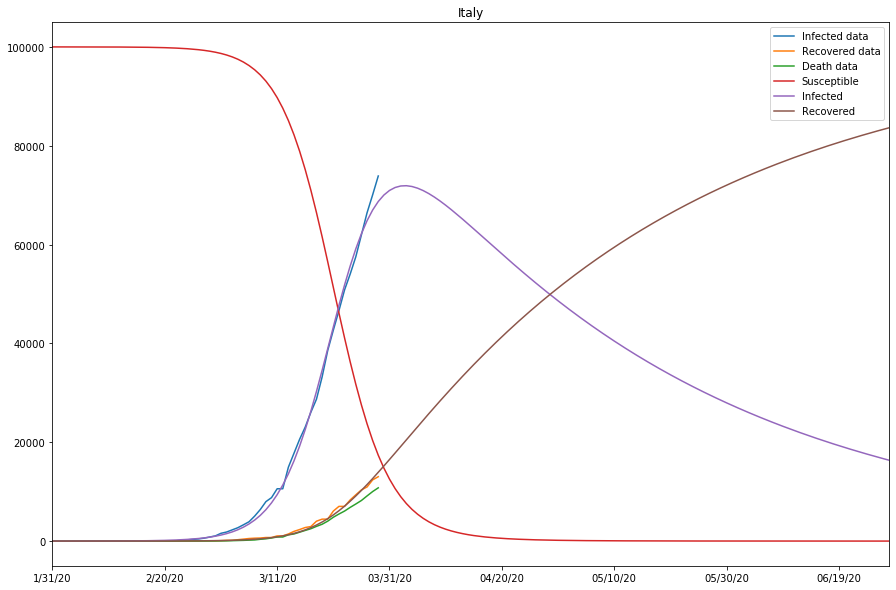

In [131]:
for country in countries:
    startdate = get_start_date(country)
    learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
    #recovered, death, data, conf = learner.train()
    learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')

In [143]:
countries = ['Korea, South']
#startdate = START_DATE
predict_range = 150
s_0 = 15000
i_0 = 2
r_0 = 0

Hi
      fun: 496.0223610437539
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.66661573, 0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 24
   status: 0
  success: True
        x: array([1.27445002e-05, 3.36348775e-02])
country=Korea, South, beta=0.00001274, gamma=0.03363488, r_0:0.00037891


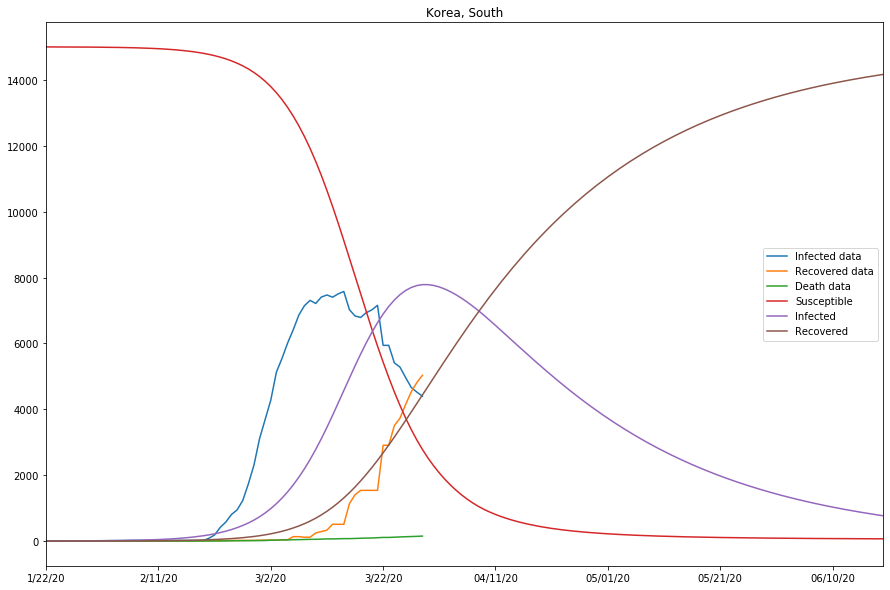

In [144]:
for country in countries:
    startdate = get_start_date(country)
    learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
    #recovered, death, data, conf = learner.train()
    learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')

Hi
      fun: 14.190117528174492
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.06958961e+02, 1.38726719e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 159
      nit: 14
   status: 0
  success: True
        x: array([9.06802941e-06, 6.93709435e-04])
country=Sweden, beta=0.00000907, gamma=0.00069371, r_0:0.01307180


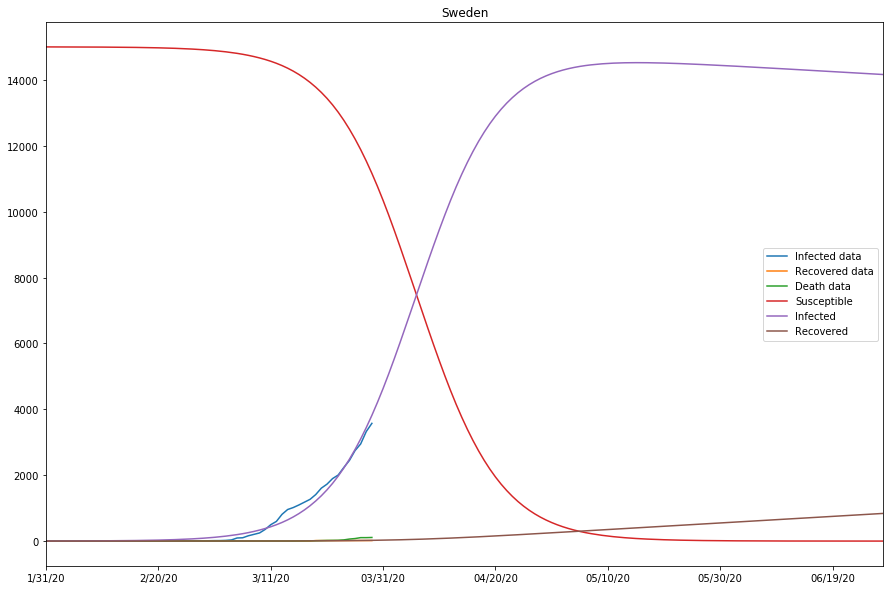

In [145]:
countries = ['Sweden']
#startdate = START_DATE
predict_range = 150
s_0 = 15000
i_0 = 2
r_0 = 0

for country in countries:
    startdate = get_start_date(country)
    learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
    #recovered, death, data, conf = learner.train()
    learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')

In [ ]:
countries = ['Sweden']
#startdate = START_DATE
predict_range = 150
s_0 = 15000
i_0 = 2
r_0 = 0

for country in countries:
    startdate = get_start_date(country)
    learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
    #recovered, death, data, conf = learner.train()
    learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')

Hi
      fun: 50.072010689132604
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.45602334e+02, -6.97670544e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 11
   status: 0
  success: True
        x: array([1.62982767e-05, 1.27433848e-04])
country=Denmark, beta=0.00001630, gamma=0.00012743, r_0:0.12789598


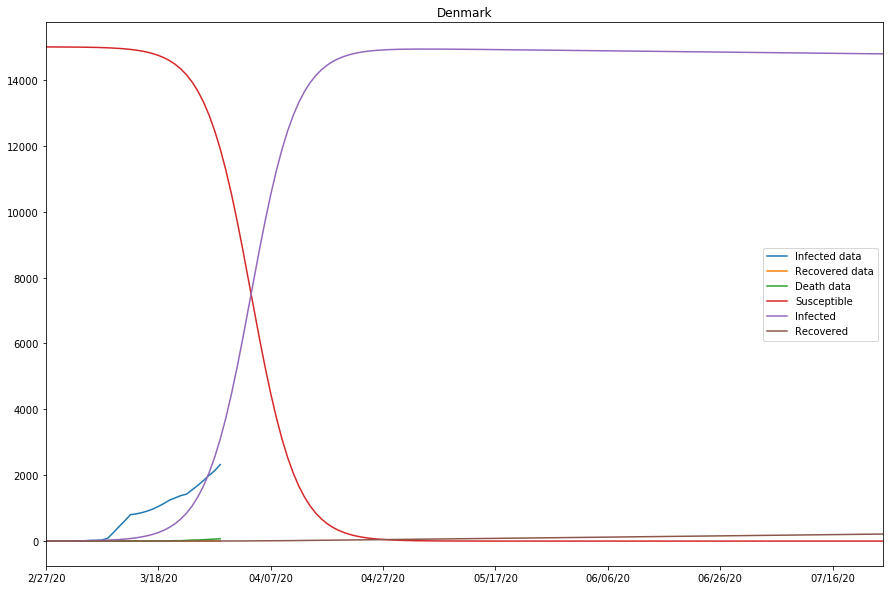

In [146]:
countries = ['Denmark']
#startdate = START_DATE
predict_range = 150
s_0 = 15000
i_0 = 2
r_0 = 0

for country in countries:
    startdate = get_start_date(country)
    learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
    #recovered, death, data, conf = learner.train()
    learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')